In [1]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from tqdm import tqdm_notebook

import multiprocessing
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
from wavelets import WaveletAnalysis
import scipy.ndimage
import pickle
import os

In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [4]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
#     'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set', LEFT HANDED
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [5]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    elif which == 'ltdlpfc':
        channel_names = ['Fp1','AF3','AF7','F1','F3','F5','F7','FC1','FC3', 'FC5']
    elif which == 'rtdlpfc':
        channel_names = ['Fp2','AF4','AF8','F2','F4','F6','F8','FC2','FC4', 'FC6']
    elif which == 'ltparietal':
        channel_names = ['P1', 'P3', 'CP1', 'CP3']
    elif which == 'rtparietal':
        channel_names = ['P2', 'P4', 'CP2', 'CP4']
    elif which == 'occipital':
        channel_names = ['PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'O1', 'Oz', 'O2']
    elif which == 'ltoccipital':
        channel_names = ['PO7', 'PO5', 'PO3', 'O1']
    elif which == 'rtoccipital':
        channel_names = ['PO4', 'PO6', 'PO8', 'O2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

In [6]:
def get_wavelet(channel, time, im_size = [1024, 1024]):
    wa = WaveletAnalysis(channel, time=time)
    power_im = np.log(wa.wavelet_power)
    power_norm = power_im - power_im.mean()
    power_norm = power_norm / power_norm.ptp()
    power_norm = np.flip(scipy.ndimage.interpolation.zoom(power_im, [im_size[0]/power_im.shape[0], im_size[1]/power_im.shape[1]], order=5, prefilter=False), axis=0)
    
    df = pd.DataFrame(data=wa.wavelet_power, columns=time / 1000)
    df.insert(0, 'frequency', wa.fourier_frequencies)
    df = df.set_index('frequency')
    return df

def save_wavelets(epoch_num, epoch, path_segments, region, save_destination):
    time = epoch['time'].values
    channel = filter_electrodes(epoch, region).drop('time', axis=1).mean(axis=1).values
    wavelet = get_wavelet(channel, time)
    filename = save_destination + '/' + path_segments[2] + '-' + path_segments[3] + '-' + path_segments[5] + '-' + str(epoch_num) + '-' + region + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(wavelet, f)

def save_wavelets_of_epoch(save_destination, epoch_num, epoch, path_segments):
    if not os.path.exists(save_destination):
        os.makedirs(save_destination)
    for region in ['all', 'ltm1', 'rtm1', 'central', 'ltdlpfc', 'rtdlpfc', 'ltparietal', 'rtparietal', 'occipital', 'ltoccipital', 'rtoccipital']:
        save_wavelets(epoch_num, epoch, path_segments, region, save_destination)

In [7]:
num_cores = multiprocessing.cpu_count()
save_destination = 'wavelets-69'
for eeg_path in tqdm_notebook(eegs):
    segments = eeg_path.split('/')
    segments = segments[:-1]
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_trials(epochs)
    results = Parallel(n_jobs=num_cores)(delayed(save_wavelets_of_epoch)(save_destination, i, epochs[i], segments) for i in range(len(epochs)))

pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set ...
Reading float f

# View saved wavelet files

wavelets-69/sub03-exp03-SP 110RMT r2-13-ltdlpfc.pickle
wavelets-69/sub12-exp02-SP 110RMT-25-rtoccipital.pickle
wavelets-69/sub03-exp01-SP 110RMT r1-16-rtm1.pickle
wavelets-69/sub08-exp01-SP 110RMT r3-3-ltdlpfc.pickle
wavelets-69/sub15-exp01-SP 110RMT r3-35-rtoccipital.pickle
wavelets-69/sub07-exp01-SP 110RMT r1-25-rtdlpfc.pickle
wavelets-69/sub07-exp01-SP 110RMT r2-23-ltm1.pickle
wavelets-69/sub16-exp01-SP 110RMT r2-37-rtm1.pickle


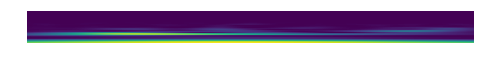

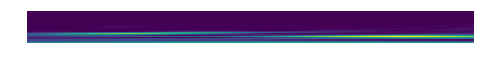

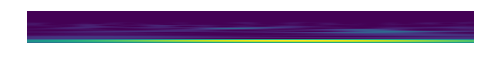

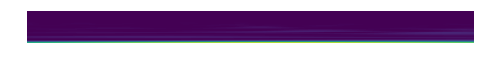

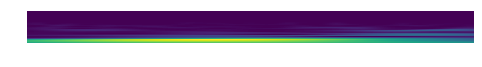

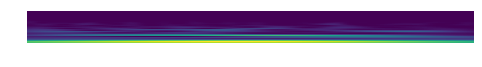

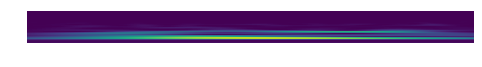

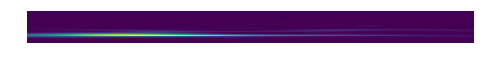

In [9]:
for wavelet_path in glob.glob(save_destination + '/*.pickle')[0:8]:
    print(wavelet_path)
    with open(wavelet_path, 'rb') as f:
        wavelet = pickle.load(f)
        fig = plt.figure(figsize=(8,8))
        plt.imshow(wavelet.values)
        plt.axis('off')

In [11]:
wavelet.columns

Float64Index([  -0.5197706879361915,   -0.5192821535393819,
                -0.5187936191425723,   -0.5183050847457628,
                -0.5178165503489531,   -0.5173280159521436,
                 -0.516839481555334,   -0.5163509471585244,
                -0.5158624127617149,   -0.5153738783649053,
              ...
                -0.0243968095712861, -0.023908275174476558,
              -0.023419740777667016, -0.022931206380857473,
               -0.02244267198404782, -0.021954137587238277,
               -0.02146560319042874, -0.020977068793619196,
              -0.020488534396809543,                 -0.02],
             dtype='float64', length=1024)